In [1]:
import numpy as np
import pandas as pd

np.random.seed(123)

n_deals = 1500

regions = ["APAC", "EMEA", "AMER"]
sectors = ["Energy", "Retail", "Tech", "Manufacturing", "Finance"]
deal_sizes = ["Small", "Medium", "Large"]

df = pd.DataFrame({
    "deal_id": np.arange(1, n_deals + 1),
    "region": np.random.choice(regions, n_deals, p=[0.3, 0.4, 0.3]),
    "sector": np.random.choice(sectors, n_deals),
    "tenor_months": np.random.choice([6, 12, 24, 36], n_deals, p=[0.2, 0.4, 0.25, 0.15]),
    "deal_size": np.random.choice(deal_sizes, n_deals, p=[0.4, 0.4, 0.2]),
})

# Base forecast volumes by deal size
size_to_volume_mu = {"Small": 1_000, "Medium": 10_000, "Large": 50_000}
df["forecast_volume"] = [
    np.random.normal(size_to_volume_mu[s], size_to_volume_mu[s] * 0.2)
    for s in df["deal_size"]
]
df["forecast_volume"] = np.clip(df["forecast_volume"], 500, None)

# Base forecast price by sector (just to have structure)
sector_to_price_mu = {
    "Energy": 65,
    "Retail": 40,
    "Tech": 120,
    "Manufacturing": 55,
    "Finance": 80,
}
df["forecast_price"] = [
    np.random.normal(sector_to_price_mu[s], sector_to_price_mu[s] * 0.1)
    for s in df["sector"]
]
df["forecast_price"] = np.clip(df["forecast_price"], 10, None)

# Forecast margin % by sector (synthetic)
sector_to_margin_pct = {
    "Energy": 0.18,
    "Retail": 0.12,
    "Tech": 0.25,
    "Manufacturing": 0.15,
    "Finance": 0.22,
}
df["forecast_margin_pct"] = [sector_to_margin_pct[s] for s in df["sector"]]

# Forecast revenue & margin
df["forecast_revenue"] = df["forecast_volume"] * df["forecast_price"]
df["forecast_margin"]  = df["forecast_revenue"] * df["forecast_margin_pct"]

# Actuals: introduce random deviations + some structure
vol_dev = np.random.normal(1.0, 0.15, size=n_deals)   # ±15% volume variance
price_dev = np.random.normal(1.0, 0.08, size=n_deals) # ±8% price variance
margin_dev = np.random.normal(1.0, 0.2, size=n_deals) # ±20% margin efficiency

df["actual_volume"] = df["forecast_volume"] * vol_dev
df["actual_price"]  = df["forecast_price"] * price_dev

# Actual revenue & margin
df["actual_revenue"] = df["actual_volume"] * df["actual_price"]
df["actual_margin"]  = df["actual_revenue"] * df["forecast_margin_pct"] * margin_dev

# Margin delta
df["margin_delta"] = df["actual_margin"] - df["forecast_margin"]

# Variance decomposition (very simplified):
# Volume variance: volume delta at forecast price & margin rate
df["volume_var"] = (
    (df["actual_volume"] - df["forecast_volume"])
    * df["forecast_price"]
    * df["forecast_margin_pct"]
)

# Price variance: price delta on actual volume
df["price_var"] = (
    (df["actual_price"] - df["forecast_price"])
    * df["actual_volume"]
    * df["forecast_margin_pct"]
)

# Residual / mix
df["mix_var"] = df["margin_delta"] - df["volume_var"] - df["price_var"]

df.to_csv("synthetic_deals_dataset.csv", index=False)
df.head()


,deal_id,region,sector,tenor_months,deal_size,forecast_volume,forecast_price,forecast_margin_pct,forecast_revenue,forecast_margin,actual_volume,actual_price,actual_revenue,actual_margin,margin_delta,volume_var,price_var,mix_var
0,1,EMEA,Retail,12,Large,53605.289548,37.242526,0.12,1.996396e+06,239567.566931,58334.138581,38.683573,2.256573e+06,227782.812092,-11784.754839,21133.713983,10087.470717,-43005.939538
1,2,APAC,Tech,12,Medium,10148.634781,111.513815,0.25,1.131713e+06,282928.244459,12853.752968,116.513382,1.497634e+06,316838.651211,33910.406752,75414.512009,16065.801316,-57569.906572
2,3,APAC,Energy,6,Medium,9825.282923,59.093303,0.18,5.806084e+05,104509.515587,9058.067197,54.537683,4.940060e+05,97549.608147,-6959.907440,-8160.716025,-7427.719627,8628.528211
3,4,EMEA,Manufacturing,12,Medium,13239.237769,57.714497,0.15,7.640959e+05,114614.391722,12017.818787,64.215660,7.717322e+05,117053.498875,2439.107153,-10574.037276,11719.470958,1293.673472
4,5,AMER,Finance,12,Small,1172.558993,89.863211,0.22,1.053699e+05,23181.381529,1174.296530,90.664838,1.064674e+05,16514.703777,-6666.677752,34.350946,207.096486,-6908.125184


In [3]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

plt.rcParams["figure.figsize"] = (10, 4)


In [4]:
# 2. Load data
df = pd.read_csv("synthetic_deals_dataset.csv")
df.head()
df.describe(include="all")


,deal_id,region,sector,tenor_months,deal_size,forecast_volume,forecast_price,forecast_margin_pct,forecast_revenue,forecast_margin,actual_volume,actual_price,actual_revenue,actual_margin,margin_delta,volume_var,price_var,mix_var
count,1500.000000,1500,1500,1500.000000,1500,1500.000000,1500.000000,1500.000000,1.500000e+03,1.500000e+03,1500.000000,1500.000000,1.500000e+03,1.500000e+03,1500.000000,1500.000000,1500.000000,1500.000000
unique,NaN,3,5,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,EMEA,Tech,NaN,Medium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,593,325,NaN,607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,750.500000,NaN,NaN,17.552000,NaN,14340.100518,72.444548,0.184687,1.024718e+06,2.065883e+05,14402.180970,72.667486,1.039386e+06,2.105370e+05,3948.647566,2424.797763,885.224784,638.625020
std,433.157015,NaN,NaN,10.111947,NaN,18527.794186,28.792377,0.047108,1.477493e+06,3.393760e+05,18822.090390,29.657644,1.539152e+06,3.623590e+05,98981.037082,58804.291930,35872.193506,72925.720452
min,1.000000,NaN,NaN,6.000000,NaN,500.000000,24.733498,0.120000,1.978838e+04,2.374605e+03,407.287871,22.486403,1.543558e+04,1.355230e+03,-742683.529466,-472863.774002,-414613.012216,-643202.702873
25%,375.750000,NaN,NaN,12.000000,NaN,1086.188865,51.327168,0.150000,7.746675e+04,1.565486e+04,1106.318931,50.770149,7.987316e+04,1.565794e+04,-9975.703309,-4163.122817,-2512.991100,-6862.276139
50%,750.500000,NaN,NaN,12.000000,NaN,8812.762071,64.278273,0.180000,4.865461e+05,7.326386e+04,8595.375586,64.717765,4.808948e+05,6.861912e+04,-158.385352,156.364436,49.875961,-13.096292
75%,1125.250000,NaN,NaN,24.000000,NaN,12411.694564,87.634529,0.220000,1.151937e+06,2.362417e+05,13511.572177,88.929248,1.132170e+06,2.313039e+05,10223.635132,6890.683605,3220.833361,7732.101950


In [5]:

# 3. Quick sanity checks

print(df[["region", "sector", "deal_size"]].nunique())
print(df[["forecast_margin", "actual_margin", "margin_delta"]].describe())


region       3
sector       5
deal_size    3
dtype: int64
       forecast_margin  actual_margin   margin_delta
count     1.500000e+03   1.500000e+03    1500.000000
mean      2.065883e+05   2.105370e+05    3948.647566
std       3.393760e+05   3.623590e+05   98981.037082
min       2.374605e+03   1.355230e+03 -742683.529466
25%       1.565486e+04   1.565794e+04   -9975.703309
50%       7.326386e+04   6.861912e+04    -158.385352
75%       2.362417e+05   2.313039e+05   10223.635132
max       2.144576e+06   2.918541e+06  833674.698522


In [6]:
# 4. Basic margin summary

# Overall
print("\nOverall margin stats:")
print(df[["forecast_margin", "actual_margin", "margin_delta"]].describe())

# By region
region_summary = df.groupby("region")["margin_delta"].agg(["mean","median","count"])
print("\nMargin delta by region:")
print(region_summary)

# By sector
sector_summary = df.groupby("sector")["margin_delta"].agg(["mean","median","count"])
print("\nMargin delta by sector:")
print(sector_summary)




Overall margin stats:
       forecast_margin  actual_margin   margin_delta
count     1.500000e+03   1.500000e+03    1500.000000
mean      2.065883e+05   2.105370e+05    3948.647566
std       3.393760e+05   3.623590e+05   98981.037082
min       2.374605e+03   1.355230e+03 -742683.529466
25%       1.565486e+04   1.565794e+04   -9975.703309
50%       7.326386e+04   6.861912e+04    -158.385352
75%       2.362417e+05   2.313039e+05   10223.635132
max       2.144576e+06   2.918541e+06  833674.698522

Margin delta by region:
               mean      median  count
region                                
AMER    4871.603504  243.918840    452
APAC   -2883.032339 -805.854981    455
EMEA    8486.992040    2.229829    593

Margin delta by sector:
                       mean       median  count
sector                                         
Energy          1025.688159  -667.400581    309
Finance          449.967071  -602.074646    273
Manufacturing   1587.667874  -217.558672    298
Retail         

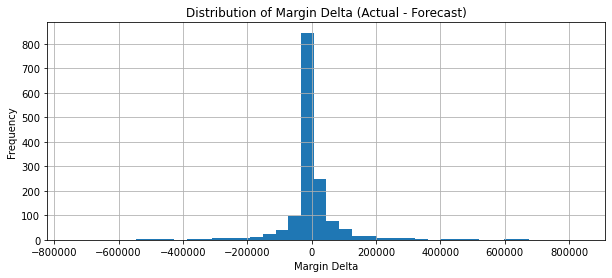

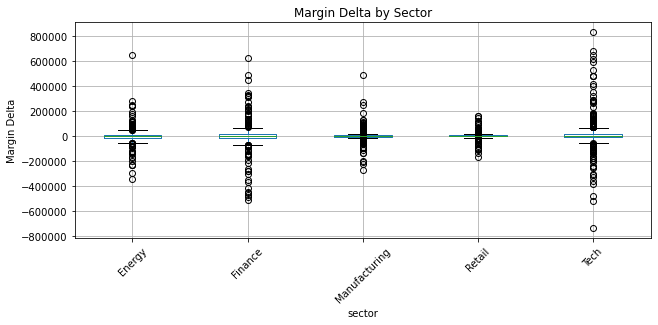

In [7]:
# 5. Visualise distribution of margin_delta

df["margin_delta"].hist(bins=40)
plt.title("Distribution of Margin Delta (Actual - Forecast)")
plt.xlabel("Margin Delta")
plt.ylabel("Frequency")
plt.show()

# Boxplot by sector (simple)
df.boxplot(column="margin_delta", by="sector", rot=45)
plt.title("Margin Delta by Sector")
plt.suptitle("")
plt.ylabel("Margin Delta")
plt.show()




Total variance components:
volume_var    3.637197e+06
price_var     1.327837e+06
mix_var       9.579375e+05
dtype: float64

Variance share:
volume_var    0.614083
price_var     0.224184
mix_var       0.161733
dtype: float64


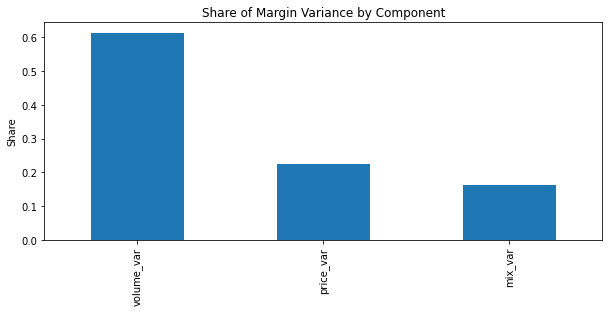

In [8]:
# 6. Variance contributions (volume, price, mix)

var_summary = df[["volume_var", "price_var", "mix_var"]].sum()
print("\nTotal variance components:")
print(var_summary)

# Convert to % share
var_share = var_summary / var_summary.sum()
print("\nVariance share:")
print(var_share)

var_share.plot(kind="bar")
plt.title("Share of Margin Variance by Component")
plt.ylabel("Share")
plt.show()


Decision tree R^2 on training data: 0.04729684976256654


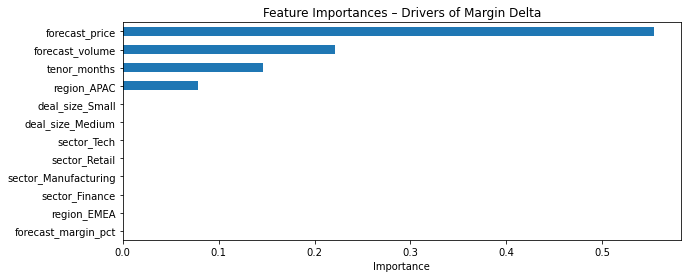

In [9]:
# 7. Driver tree on margin_delta

# Prepare features (numerical + encoded categoricals)
model_df = df.copy()

# Convert categoricals to dummies
X = pd.get_dummies(
    model_df[[
        "region",
        "sector",
        "deal_size",
        "tenor_months",
        "forecast_volume",
        "forecast_price",
        "forecast_margin_pct",
    ]],
    drop_first=True
)
y = model_df["margin_delta"]

tree = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=30,
    random_state=42
)
tree.fit(X, y)

y_pred = tree.predict(X)
print("\nDecision tree R^2 on training data:", r2_score(y, y_pred))

# Feature importances
importances = pd.Series(tree.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

importances.plot(kind="barh")
plt.title("Feature Importances – Drivers of Margin Delta")
plt.xlabel("Importance")
plt.show()

In [10]:
# 8. Segment-level insights – Top gainers / losers

seg = df.groupby(["region", "sector"]).agg(
    deals=("deal_id", "count"),
    avg_forecast_margin=("forecast_margin", "mean"),
    avg_actual_margin=("actual_margin", "mean"),
    avg_margin_delta=("margin_delta", "mean")
).reset_index()

print("\nTop 10 segments by positive margin delta:")
print(seg.sort_values("avg_margin_delta", ascending=False).head(10))

print("\nBottom 10 segments by margin underperformance:")
print(seg.sort_values("avg_margin_delta", ascending=True).head(10))



Top 10 segments by positive margin delta:
   region         sector  deals  avg_forecast_margin  avg_actual_margin  \
14   EMEA           Tech    135        310711.104833      332178.106748   
2    AMER  Manufacturing     83         86677.411374       96610.187322   
10   EMEA         Energy    111        191569.170771      201428.914671   
4    AMER           Tech     88        511273.760641      520979.287459   
11   EMEA        Finance    107        256240.029031      264013.312275   
9    APAC           Tech    102        397443.094508      403709.922797   
1    AMER        Finance    100        330813.193336      337073.648108   
13   EMEA         Retail    113         79541.777316       84505.385628   
3    AMER         Retail     87         75088.125408       76832.208021   
7    APAC  Manufacturing     88        106008.797096      106020.435969   

    avg_margin_delta  
14      21467.001916  
2        9932.775948  
10       9859.743900  
4        9705.526818  
11       7773.28

In [11]:
# 9. Simple "what-if" uplift calc:
# Suppose we improved deals with negative margin_delta by 50%

underperforming = df[df["margin_delta"] < 0]
uplift_potential = -0.5 * underperforming["margin_delta"].sum()

print(f"\nIf we recovered 50% of losses on underperforming deals,")
print(f"we could improve total margin by approximately {uplift_potential:,.0f} units.")


If we recovered 50% of losses on underperforming deals,
we could improve total margin by approximately 14,951,170 units.
